# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall Mean Featureset

## Import relevant libraries

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [46]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [47]:
df_essentia_best_overall_features_mean = pd.read_csv(get_deam_path('processed/features/normalised_essentia_best_overall_features_mean.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_features_mean = df_essentia_best_overall_features_mean[df_essentia_best_overall_features_mean.columns[1:]]

df_essentia_best_overall_features_mean

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,2,0.023745,0.224209,0.054855,0.392382,0.631265,0.625832,0.593381,0.579839,0.267674,...,0.023256,0.010375,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672
1,3,0.082083,0.348482,0.211289,0.402792,0.543954,0.677312,0.677951,0.907102,0.118704,...,0.000000,0.000000,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942
2,4,0.018062,0.213582,0.084731,0.661722,0.554446,0.593904,0.570916,0.686407,0.209877,...,0.000000,0.001484,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057
3,5,0.016018,0.181322,0.041096,0.651524,0.395875,0.900862,0.900318,0.274781,0.429967,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199
4,7,0.107675,0.349349,0.197274,0.181959,0.602087,0.450784,0.432106,0.938413,0.080032,...,0.000000,0.000000,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.013781,0.186248,0.077709,0.476088,0.626271,0.772039,0.770549,0.239129,0.649168,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164
1740,1997,0.012825,0.189153,0.073405,0.471430,0.576407,0.551288,0.577018,0.631457,0.278428,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132
1741,1998,0.016787,0.199106,0.055710,0.467379,0.654543,0.722595,0.743935,0.634282,0.178965,...,0.000000,0.017823,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058
1742,1999,0.022245,0.224935,0.054033,0.255286,0.625434,0.669501,0.701341,0.558181,0.293156,...,0.068617,0.016337,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720


In [48]:
df_essentia_best_overall_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   song_id                                  1744 non-null   int64  
 1   lowlevel.melbands_kurtosis.mean          1744 non-null   float64
 2   lowlevel.melbands_skewness.mean          1744 non-null   float64
 3   lowlevel.spectral_energy.mean            1744 non-null   float64
 4   tonal.chords_strength.mean               1744 non-null   float64
 5   tonal.hpcp_entropy.mean                  1744 non-null   float64
 6   tonal.key_edma.strength                  1744 non-null   float64
 7   tonal.key_temperley.strength             1744 non-null   float64
 8   rhythm.beats_loudness_band_ratio.mean_0  1744 non-null   float64
 9   rhythm.beats_loudness_band_ratio.mean_1  1744 non-null   float64
 10  rhythm.beats_loudness_band_ratio.mean_2  1744 no

Join both the featureset and annotation set together

In [49]:
df_essentia_best_overall_features_mean_whole = pd.merge(df_essentia_best_overall_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_features_mean_whole = df_essentia_best_overall_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_overall_features_mean_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,0.023745,0.224209,0.054855,0.392382,0.631265,0.625832,0.593381,0.579839,0.267674,0.163056,...,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672,-0.475,-0.500
1,0.082083,0.348482,0.211289,0.402792,0.543954,0.677312,0.677951,0.907102,0.118704,0.015192,...,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942,-0.375,-0.425
2,0.018062,0.213582,0.084731,0.661722,0.554446,0.593904,0.570916,0.686407,0.209877,0.085901,...,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057,0.175,0.125
3,0.016018,0.181322,0.041096,0.651524,0.395875,0.900862,0.900318,0.274781,0.429967,0.346099,...,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199,-0.150,0.075
4,0.107675,0.349349,0.197274,0.181959,0.602087,0.450784,0.432106,0.938413,0.080032,0.025854,...,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.013781,0.186248,0.077709,0.476088,0.626271,0.772039,0.770549,0.239129,0.649168,0.208802,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164,-0.275,0.225
1740,0.012825,0.189153,0.073405,0.471430,0.576407,0.551288,0.577018,0.631457,0.278428,0.138446,...,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132,0.075,-0.275
1741,0.016787,0.199106,0.055710,0.467379,0.654543,0.722595,0.743935,0.634282,0.178965,0.163915,...,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058,0.350,0.300
1742,0.022245,0.224935,0.054033,0.255286,0.625434,0.669501,0.701341,0.558181,0.293156,0.168323,...,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [50]:
features = df_essentia_best_overall_features_mean.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,0.023745,0.224209,0.054855,0.392382,0.631265,0.625832,0.593381,0.579839,0.267674,0.163056,...,0.023256,0.010375,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672
1,0.082083,0.348482,0.211289,0.402792,0.543954,0.677312,0.677951,0.907102,0.118704,0.015192,...,0.000000,0.000000,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942
2,0.018062,0.213582,0.084731,0.661722,0.554446,0.593904,0.570916,0.686407,0.209877,0.085901,...,0.000000,0.001484,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057
3,0.016018,0.181322,0.041096,0.651524,0.395875,0.900862,0.900318,0.274781,0.429967,0.346099,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199
4,0.107675,0.349349,0.197274,0.181959,0.602087,0.450784,0.432106,0.938413,0.080032,0.025854,...,0.000000,0.000000,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.013781,0.186248,0.077709,0.476088,0.626271,0.772039,0.770549,0.239129,0.649168,0.208802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164
1740,0.012825,0.189153,0.073405,0.471430,0.576407,0.551288,0.577018,0.631457,0.278428,0.138446,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132
1741,0.016787,0.199106,0.055710,0.467379,0.654543,0.722595,0.743935,0.634282,0.178965,0.163915,...,0.000000,0.017823,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058
1742,0.022245,0.224935,0.054033,0.255286,0.625434,0.669501,0.701341,0.558181,0.293156,0.168323,...,0.068617,0.016337,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720


In [51]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [53]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [54]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [55]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [56]:
num_epochs = 296

Set a random seed to ensure consistent initial weights of the neural network

In [57]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [58]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [59]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 37])


Training loop

In [60]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [61]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6117393889666376
Epoch 2, Loss: 0.6100286499315085
Epoch 3, Loss: 0.6083391384170024
Epoch 4, Loss: 0.606697828515189
Epoch 5, Loss: 0.6051904346316515
Epoch 6, Loss: 0.6036947287065404
Epoch 7, Loss: 0.6022119607990583
Epoch 8, Loss: 0.6007433925254181
Epoch 9, Loss: 0.599289078545509
Epoch 10, Loss: 0.5978484249936177
Epoch 11, Loss: 0.5964208063153662
Epoch 12, Loss: 0.5953973954910371
Epoch 13, Loss: 0.5943932060959207
Epoch 14, Loss: 0.5933711449445846
Epoch 15, Loss: 0.5923408551297583
Epoch 16, Loss: 0.5913077621391112
Epoch 17, Loss: 0.5902755369505391
Epoch 18, Loss: 0.5892467888448013
Epoch 19, Loss: 0.588223537334592
Epoch 20, Loss: 0.5872073844884498
Epoch 21, Loss: 0.5861995111209622
Epoch 22, Loss: 0.585200978544451
Epoch 23, Loss: 0.5842126253535979
Epoch 24, Loss: 0.5832351675767833
Epoch 25, Loss: 0.5822692230985602
Epoch 26, Loss: 0.5813153107159604
Epoch 27, Loss: 0.580373874884227
Epoch 28, Loss: 0.5794452850111784
Epoch 29, Loss: 0.5785298605229274

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [62]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 37])


Generating scores

In [66]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [67]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2616314230270348
Valence RMSE: 0.24807171346580964
Arousal RMSE: 0.2745221812685447
Test R^2 score: tensor([0.2542, 0.2538], dtype=torch.float64)
Test Adjusted R^2 score: tensor([0.1655, 0.1650], dtype=torch.float64)
Test R^2 score (overall): 0.25399374103874767


In [65]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_overall_mean_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[ 8.4194e-02,  7.9457e-02],
        [-2.2921e-01, -2.7805e-01],
        [ 4.1044e-03, -1.9898e-02],
        [ 1.5207e-02, -5.5610e-03],
        [-2.2692e-02, -5.4530e-02],
        [-2.5768e-01, -3.0741e-01],
        [-3.4857e-01, -3.9810e-01],
        [ 6.8547e-02,  6.1964e-02],
        [-2.2227e-01, -2.7069e-01],
        [ 9.5143e-02,  9.1590e-02],
        [ 1.5433e-01,  1.5660e-01],
        [-2.5581e-01, -3.0554e-01],
        [-3.5504e-01, -4.0452e-01],
        [ 1.5833e-01,  1.5894e-01],
        [ 1.0682e-01,  1.0436e-01],
        [ 3.1290e-02,  1.5233e-02],
        [-3.5713e-01, -4.0650e-01],
        [ 2.1819e-02,  2.9937e-03],
        [ 1.5826e-01,  1.5890e-01],
        [-1.4583e-01, -1.8959e-01],
        [-2.2603e-02, -5.4413e-02],
        [-6.1767e-02, -1.0040e-01],
        [-1.6239e-02, -4.6194e-02],
        [ 1.5646e-01,  1.5784e-01],
        [ 1.5822e-01,  1.5887e-01],
        [ 9.1298e-04, -2.4023e-02],
        [ 1.5483e-01,  1.5690e-01],
        [ 1.3280e-01,  1.327

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.2538, 0.2532], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6117393889666376
Training completed.
Training completed.
Testing model...
Test RMSE: 0.37700811848019977
Valence RMSE: 0.42234712469076646
Arousal RMSE: 0.3254122755296778
Test Adjusted R^2 score: tensor([-1.4189, -0.1733], dtype=torch.float64)
Test R^2 score: -0.6051356876437367
Num of epochs: 2
Epoch 1, Loss: 0.6117393889666376
Epoch 2, Loss: 0.6100286499315085
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3747930112159293
Valence RMSE: 0.4186348233590215
Arousal RMSE: 0.32509150586222374
Test Adjusted R^2 score: tensor([-1.3766, -0.1710], dtype=torch.float64)
Test R^2 score: -0.5851850141042266
Num of epochs: 3
Epoch 1, Loss: 0.6117393889666376
Epoch 2, Loss: 0.6100286499315085
Epoch 3, Loss: 0.6083391384170024
Training completed.
Training completed.
Testing model...
Test RMSE: 0.37264614077261776
Valence RMSE: 0.4149986527441732
Arousal RMSE: 0.3248175036631685
Test Adjusted R^2 score: tensor([-1.3355, -0.1690], dtype=torch.

### Plot graphs to visualise relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

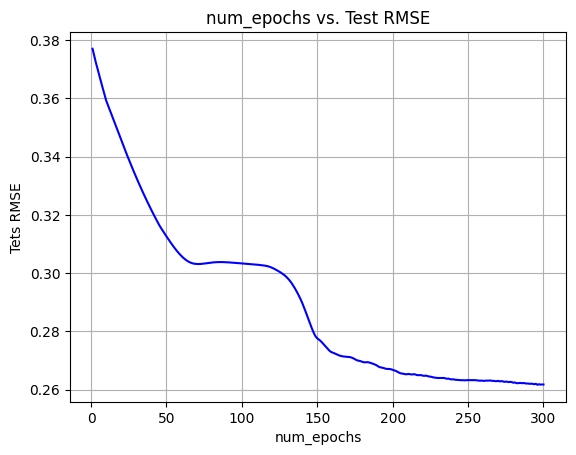

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2616314230270348
Corresponding R^2 SCore: 0.25399374103874767
Corresponding num_epochs: 296


#### Test R^2 Score vs. num_epochs

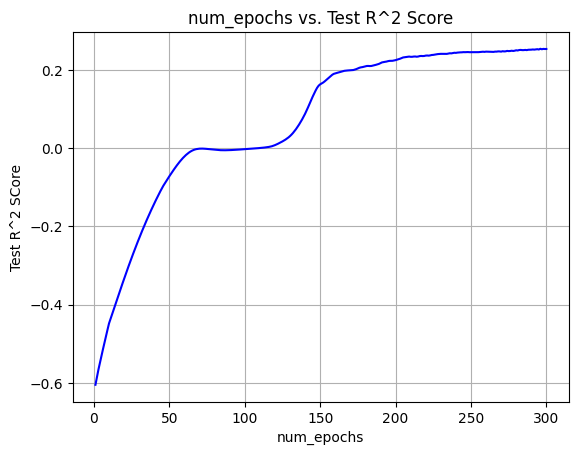

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.25399374103874767
Corresponding RMSE: 0.2616314230270348
Corresponding num_epochs: 296


#### Test Adjusted R^2 Score (Valence) vs. num_epochs

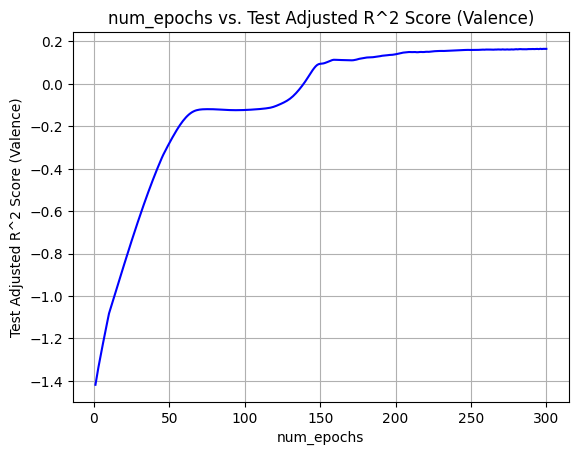

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.16547377176405476
Corresponding RMSE: 0.2616314230270348
Corresponding num_epochs: 296


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

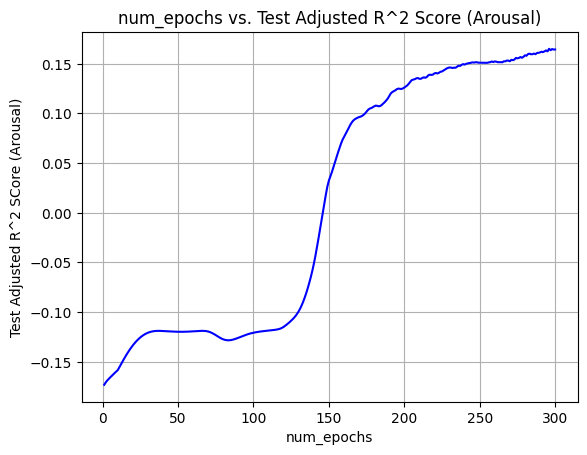

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.1650073978917923
Corresponding RMSE: 0.2616314230270348
Corresponding num_epochs: 296
